# Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

##  Загрузим данные и подготовим их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.core.display import display, HTML

visits = pd.read_csv('/datasets/visits_info_short.csv')
display(HTML("<font color='green'>---------------------------------------------</font>"))
display(HTML("<font color='green'>ОБЩАЯ ИНФОРМАЦИЯ VISITS</font>"))
display(HTML("<font color='green'>---------------------------------------------</font>"))
visits.info()
orders = pd.read_csv('/datasets/orders_info_short.csv')
display(HTML("<font color='green'>---------------------------------------------</font>"))
display(HTML("<font color='green'>ОБЩАЯ ИНФОРМАЦИЯ ORDERS</font>"))
display(HTML("<font color='green'>---------------------------------------------</font>"))
orders.info()
costs = pd.read_csv('/datasets/costs_info_short.csv')
display(HTML("<font color='green'>---------------------------------------------</font>"))
display(HTML("<font color='green'>ОБЩАЯ ИНФОРМАЦИЯ COSTS</font>"))
display(HTML("<font color='green'>---------------------------------------------</font>"))
costs.info()
events = None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Привёл названия к нижнему регистру, переименовал столбцы согласна правилам хорошего стиля.

In [3]:

visits.columns = visits.columns.str.lower()
visits = visits.rename({'user id' : 'user_id', 'session start' : 'session_start', 'session end' : 'session_end'}, axis='columns')
orders.columns = orders.columns.str.lower()
orders = orders.rename({'user id' : 'user_id','event dt' : 'event_dt'}, axis='columns')
costs.columns = costs.columns.str.lower()

### Изменил формат даты.

In [4]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] =pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

### Посчитал количество дубликатов.

In [5]:
print("Дублирующихся строк в таблице visits:", visits.duplicated().sum())
print("Дублирующихся строк в таблице orders:", orders.duplicated().sum())
print("Дублирующихся строк в таблице costs:", costs.duplicated().sum())

Дублирующихся строк в таблице visits: 0
Дублирующихся строк в таблице orders: 0
Дублирующихся строк в таблице costs: 0


### Посчитал количество пропусков.

In [6]:
print("Пропусков в таблице visits:", visits.isna().sum().sum())
print("Пропусков в таблице orders:", orders.isna().sum().sum())
print("Пропусков в таблице costs:", costs.isna().sum().sum())

Пропусков в таблице visits: 0
Пропусков в таблице orders: 0
Пропусков в таблице costs: 0


## Задам функции для расчета и анализа LTV, ROI, удержания и конверсии


### Функция для создания пользовательских профилей.

In [7]:
def get_profiles(sessions, orders,  ad_costs, ):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

   
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчёта удержания.

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

###  Функция для расчёта конверсии.

In [9]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

###  Функция для расчёта LTV и ROI.

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

   
    
    
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания фрейма.

In [11]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания.

In [12]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для визуализации конверсии.

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI.

In [14]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

##  Проведём исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Максимальную и минимальную дату привлечения пользователей.
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Определяем минимальную и максимальную дату привлечения пользователей.

In [15]:
profiles = get_profiles(visits, orders,costs)
print("Минимальная дата привлечения пользлвателей:", profiles['dt'].min())
print("Максимальная дата привлечения пользлвателей:",profiles['dt'].max())

Минимальная дата привлечения пользлвателей: 2019-05-01
Максимальная дата привлечения пользлвателей: 2019-10-27


###  Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [16]:
display(HTML("<font color='green'>---------------------------------------------------------</font>"))
display(HTML("<font color='green'>Страны дающие больше всего выручки</font>"))
display(HTML("<font color='green'>---------------------------------------------------------</font>"))
display(
    profiles.groupby('region').agg({'user_id' : 'nunique','payer': ['sum', 'mean']}).sort_values(by='region', ascending = True))

user_id payer          
              nunique   sum      mean
region                               
France          17450   663  0.037994
Germany         14981   616  0.041119
UK              17575   700  0.039829
United States  100002  6902  0.069019

<p style="color:#008080;"> ЖИТЕЛИ США ПРЕДСКАЗУЕМО ОБХОДЯТ ВСЕХ ПО КОЛИЧЕСТВУ И СУММЕ СРЕДСТ ТАК КАК НАСЕЛЕНИЯ США БОЛЬШЕ ЧЕМ НАСЕЛЕНИЕ ВСЕХ 3 СТРАН ВМЕСТЕ ВЗЯТЫХ</p>

### Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [17]:
display(HTML("<font color='green'>-----------------------------------------------------</font>"))
display(HTML("<font color='green'>Устройста платящих пользователей</font>"))
display(HTML("<font color='green'>-----------------------------------------------------</font>"))
display(
    profiles.groupby('device').agg({'user_id' : 'nunique','payer': ['sum', 'mean']}).sort_values(by='device', ascending = True))

user_id payer          
        nunique   sum      mean
device                         
Android   35032  2050  0.058518
Mac       30042  1912  0.063644
PC        30455  1537  0.050468
iPhone    54479  3382  0.062079

<p style="color:#008080;">IPHONE ЛИДИРУЕТ КАК ПО СУММЕ ЗАРАБОТАННЫХ СРЕДСТ ТАК И ПО КОЛИЧЕСТВУКЛИЕНТОВ, СЛЕДОМ ИДЁТ ANDROID C ПРИЛИЧНЫМ ОТСТАВАНИЕМ PC И MAC ПРИБЛИЗИТЕЛЬНО РАВНЫ ПО КОЛИЧЕСТВУ ПОЛЬЗОВАТЕЛЕЙ, НО ПО СУММЕ КЛИЕНТЫ MAC ПРИНОСЯТ БОЛЬШЕ СРЕДСТВ</p>

### Выясним рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [18]:
display(HTML("<font color='green'>---------------------------------------------------------------------------</font>"))
display(HTML("<font color='green'>Каналы рекламы приносящие наибольшую прибыль</font>"))
display(HTML("<font color='green'>---------------------------------------------------------------------------</font>"))

display(
    profiles.groupby('channel').agg({'user_id' : 'nunique','payer': ['sum', 'mean']}).sort_values(by='channel', ascending = True))

user_id payer          
                   nunique   sum      mean
channel                                   
AdNonSense            3880   440  0.113402
FaceBoom             29144  3557  0.122049
LeapBob               8553   262  0.030633
MediaTornado          4364   156  0.035747
OppleCreativeMedia    8605   233  0.027077
RocketSuperAds        4448   352  0.079137
TipTop               19561  1878  0.096007
WahooNetBanner        8553   453  0.052964
YRabbit               4312   165  0.038265
lambdaMediaAds        2149   225  0.104700
organic              56439  1160  0.020553

<p style="color:#008080;">ТОП 3 ЛИДЕРА ПРИВЛЕЧЕНИЯ ПЛАТЯЩИХ КЛИЕНТОВ ПО КОЛИЧЕСТВУ
1.ORGANIC
2.FACEBOOM
3.TIPTOP
ТОП 3 ЛИДЕРА ПРИВЛЕЧЕНИЯ ПЛАТЯЩИХ КЛИЕНТОВ ПО СУММЕ
1.FACEBOOM
2.TIPTOP
3.ORGANIC
МЫ ВИДИМ ЧТО КОЛИЧЕСТВО ПРИВЛЕЧЕННЫЙ КЛИЕНТОВ НЕ РАВНО СУММЕ ДОХОДА
ТАК НАПРИМЕР ORGANIC ОБХОДИТ FACEBOOM ПО КОЛИЧЕТВУ ПРИВЛЕЧЕННЫХ КЛИЕНТОВ, НО ЗНАЧИТЕЛЬНО УСТУПАЕТ В СУММЕ ЗАРАБОТАННЫХ СРЕДСТВ </p>

<p style="color:#008080;">НА ДАННОМ ЭТАПЕ ИССЛЕДОВАНИЕ ВСЁ В ПОРЯДКЕ И НЕ КАКИХ АНОМАЛИЙ НЕ ЗАМЕЧЕННО. ДВИГАЕМСЯ ДАЛЬШЕ.</p>

## Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Посчитаем общую сумму расходов на маркетинг. 

In [19]:
display(HTML("<font color='green'>-----------------------------------------------------</font>"))
display(HTML("<font color='green'>Всего потраченно денег на рекламу:</font>"),costs['costs'].sum())
display(HTML("<font color='green'>-----------------------------------------------------</font>"))

105497.30000000002

### Выясним, как траты распределены по источникам.

/tmp/ipykernel_144/174846592.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  costs['week'] = pd.to_datetime(costs['dt']).dt.week


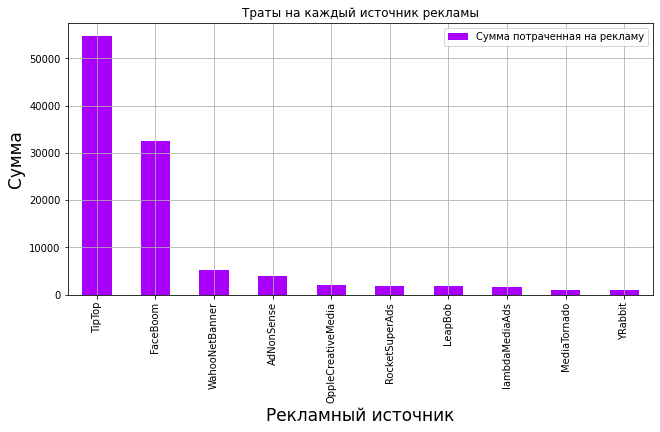

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


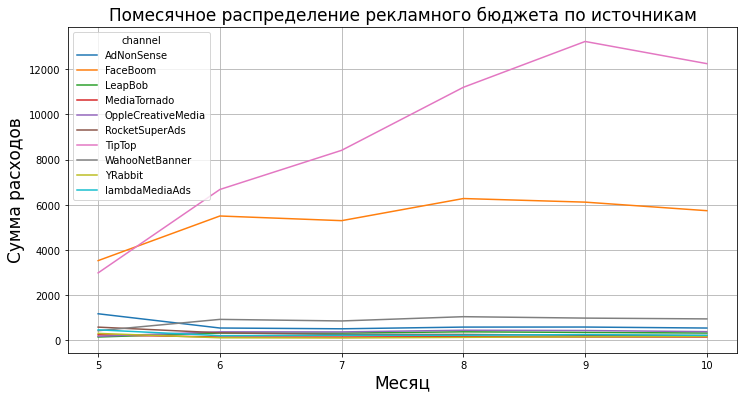

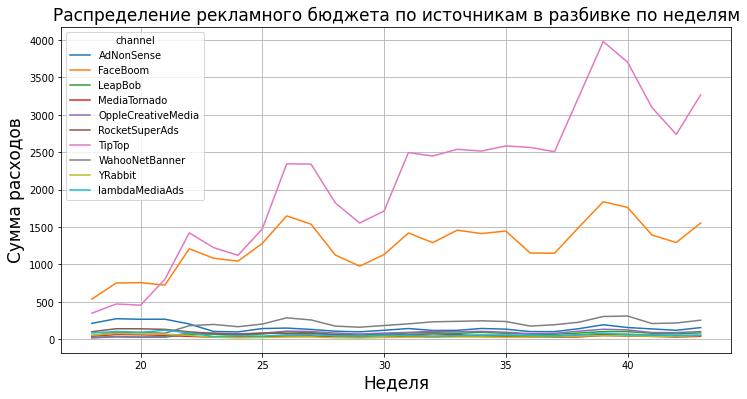

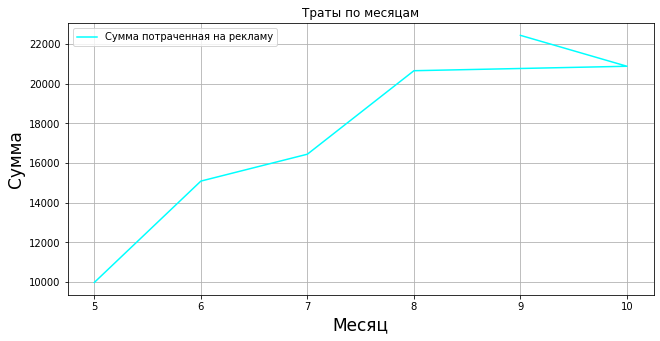

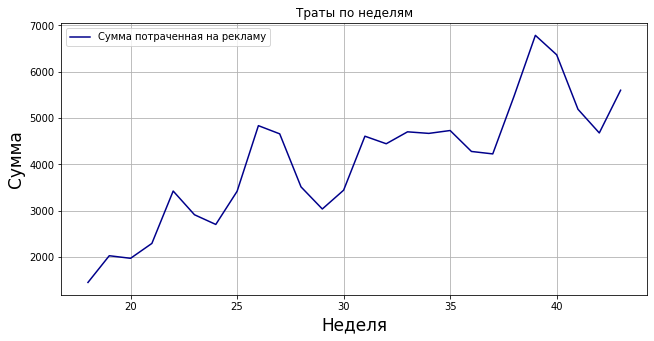

In [20]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.week

(costs.groupby('channel').agg({'costs': 'sum'})
                        .sort_values(by='costs', ascending = False)
                        .plot(kind = 'bar',title = 'Траты на каждый источник рекламы',color = '#a900fe',figsize=(10.5,5),grid =True))


plt.xlabel('Рекламный источник',fontsize=17)
plt.ylabel('Сумма',fontsize=17)
plt.legend(['Сумма потраченная на рекламу'])
plt.show()

channel_sum = costs.groupby('channel').agg({'costs': 'sum'})   
display(channel_sum.sort_values(by='costs', ascending = False))


 

costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(figsize=(12,6),grid=True);
plt.title('Помесячное распределение рекламного бюджета по источникам',fontsize=17);
plt.xlabel('Месяц',fontsize=17);
plt.ylabel('Сумма расходов',fontsize=17);
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(figsize=(12,6),grid=True);
plt.title('Распределение рекламного бюджета по источникам в разбивке по неделям',fontsize=17);
plt.xlabel('Неделя',fontsize=17);
plt.ylabel('Сумма расходов',fontsize=17);



(costs.groupby('month').agg({'costs': 'sum'}) 
                        .sort_values(by='costs', ascending = True)
                        .plot(title = 'Траты по месяцам',color = '#00FFFF',figsize=(10.5,5),grid =True))
plt.xlabel('Месяц',fontsize=17)
plt.ylabel('Сумма',fontsize=17)
plt.legend(['Сумма потраченная на рекламу'])
plt.show()

(costs.groupby('week').agg({'costs': 'sum'})
                        .sort_values(by='week', ascending = True)
                        .plot(title = 'Траты по неделям',color = '#00008B',figsize=(10.5,5),grid =True))
plt.xlabel('Неделя',fontsize=17)
plt.ylabel('Сумма',fontsize=17)
plt.legend(['Сумма потраченная на рекламу'])

plt.show()


<p style="color:#008080;">Больше всего средств потраченно на рекламу в TipTop и FaceBoom, на TipTop больше, но клиенты FaceBoom приносят куда больше средств,из чего можно сделать вывод что более продуктивно вкладывать в этот канал привлечения.
Мы видим что лишь в один месяц кампания потратила на рекламу менее чем 15 000 и это 5 меясц, в остальные же месяцы кампания лишь наращивала вложения средств в продвижение.
В разбивке источников по времени мы видим что маркетологи вкладывали колосальные средства, превышающие в несколько раз остальные источники трафика в такие источники как FaceBoom и TipTop.
</p>

<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.5</b>
    
  ✔️ Да! По таким графикам сразу видим "лидеров"! 🙂
</div>

### Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [21]:
profiles = get_profiles(visits, orders,costs)
profiles = profiles.query('channel != "organic"')

display(HTML("<font color='green'>-------------------------------------------------------------------------------------------------------</font>"))
display(HTML("<font color='green'>Средняя стоимость привлечения одного клиента для всех источников</font>"),profiles['acquisition_cost'].mean())
display(HTML("<font color='green'>-------------------------------------------------------------------------------------------------------</font>"))
display(HTML("<font color='green'>-------------------------------------------------------------------------------------------------------</font>"))
display(HTML("<font color='green'>Средняя стоимость привлечения одного клиента для каждого источника</font>"))
display(HTML("<font color='green'>-------------------------------------------------------------------------------------------------------</font>"))

display(
    profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending = False))

1.1274813239427588

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


<p style="color:#008080;">Наши гипотеза подвержается в среднем один платящий клиент из источника TipTop обходится более чем в 2 раза дороже чем один клиент в FaceBoom, но при этом доход в 2 раза ниже. </p>

## Проанализируем окупаемость рекламы.

### Общая окупаемость рекламы.

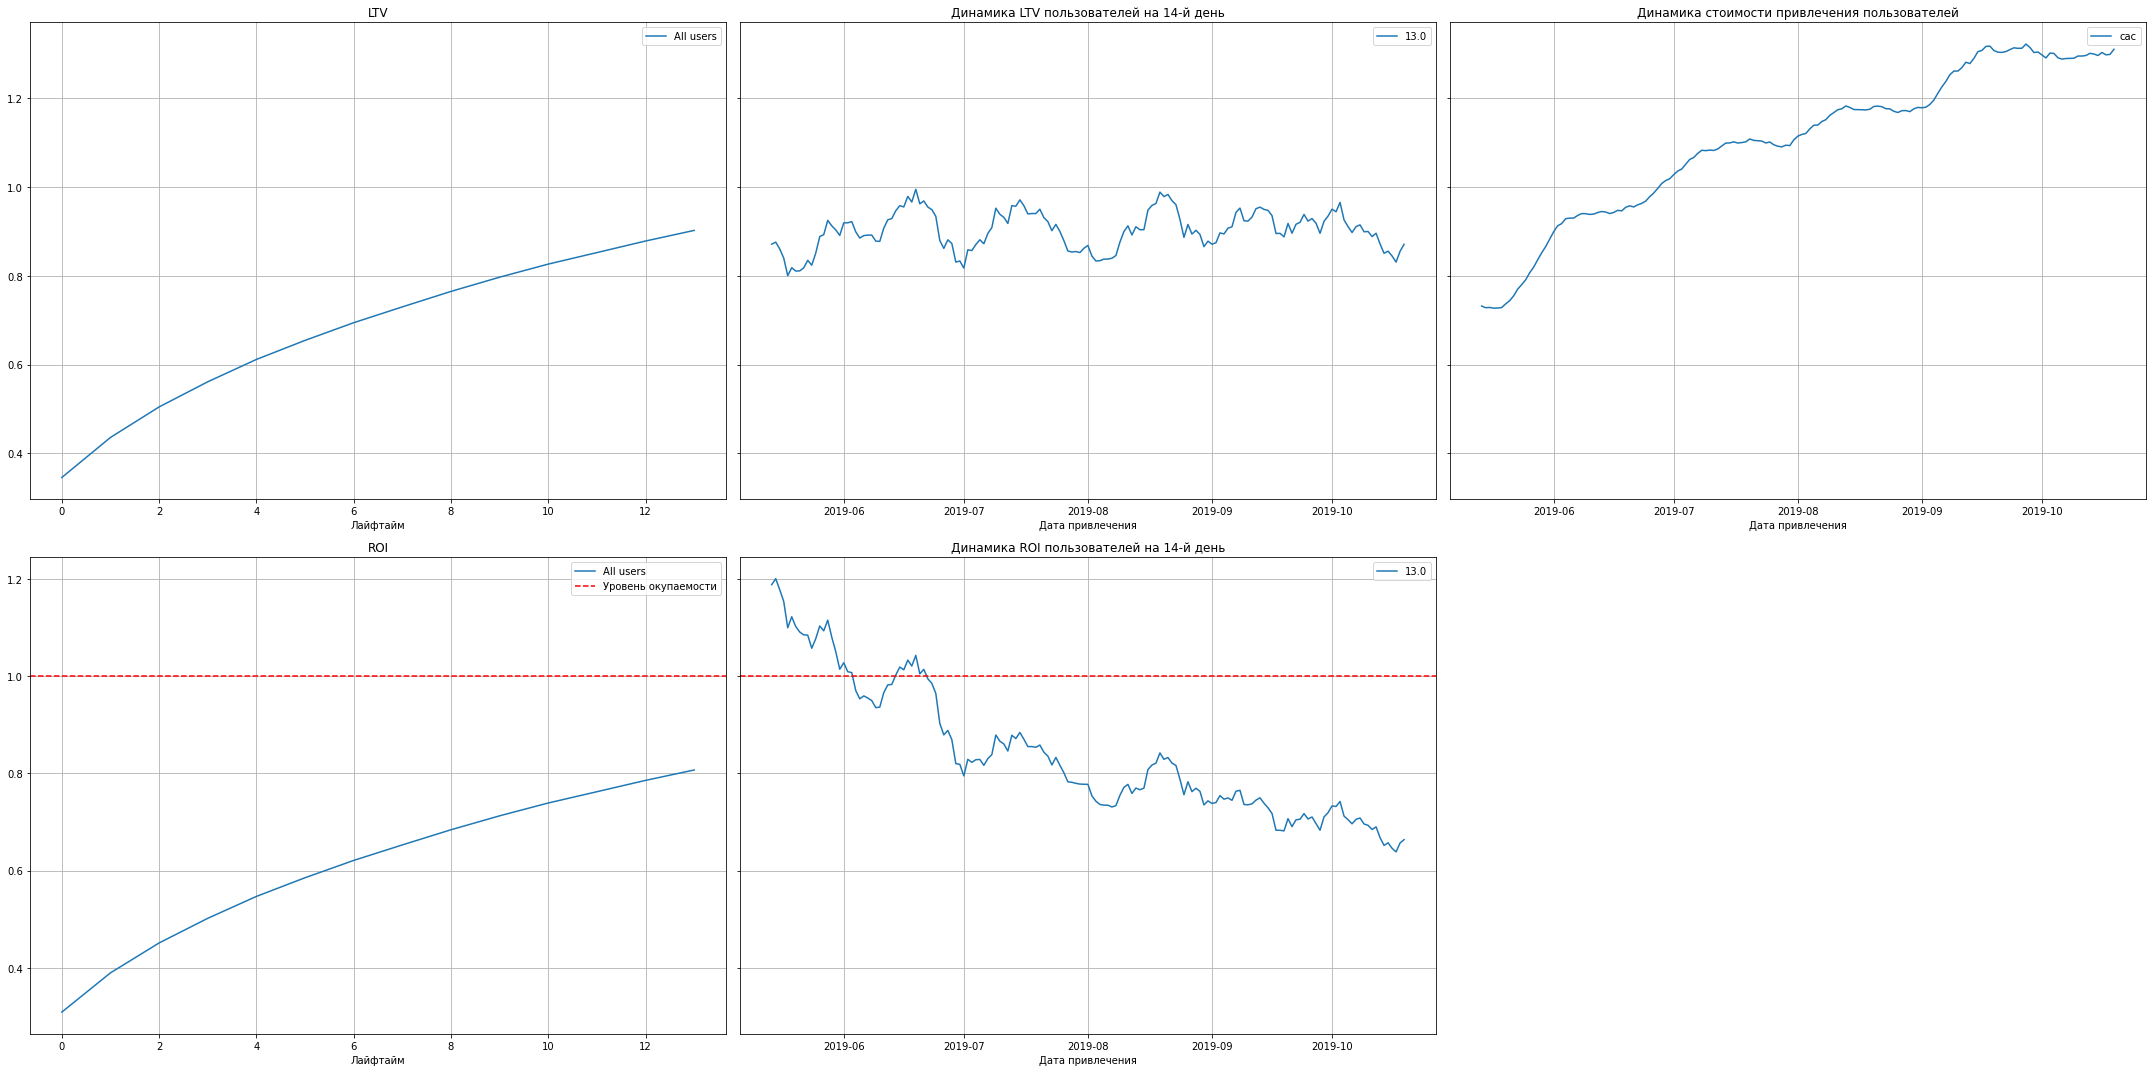

In [22]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<p style="color:#008080;">Окупаемость ROI ровна примерно 80%. По ROI динамике можно сказать что с июня реклама приносила лишь убытки, за небольшим исключением. Сделав срез и исключив органический пользователей CAC существенно вырос, с 0.5 до 0.7.
</p>

### Окупаемость рекламы с разбивкой по рекламным каналам.

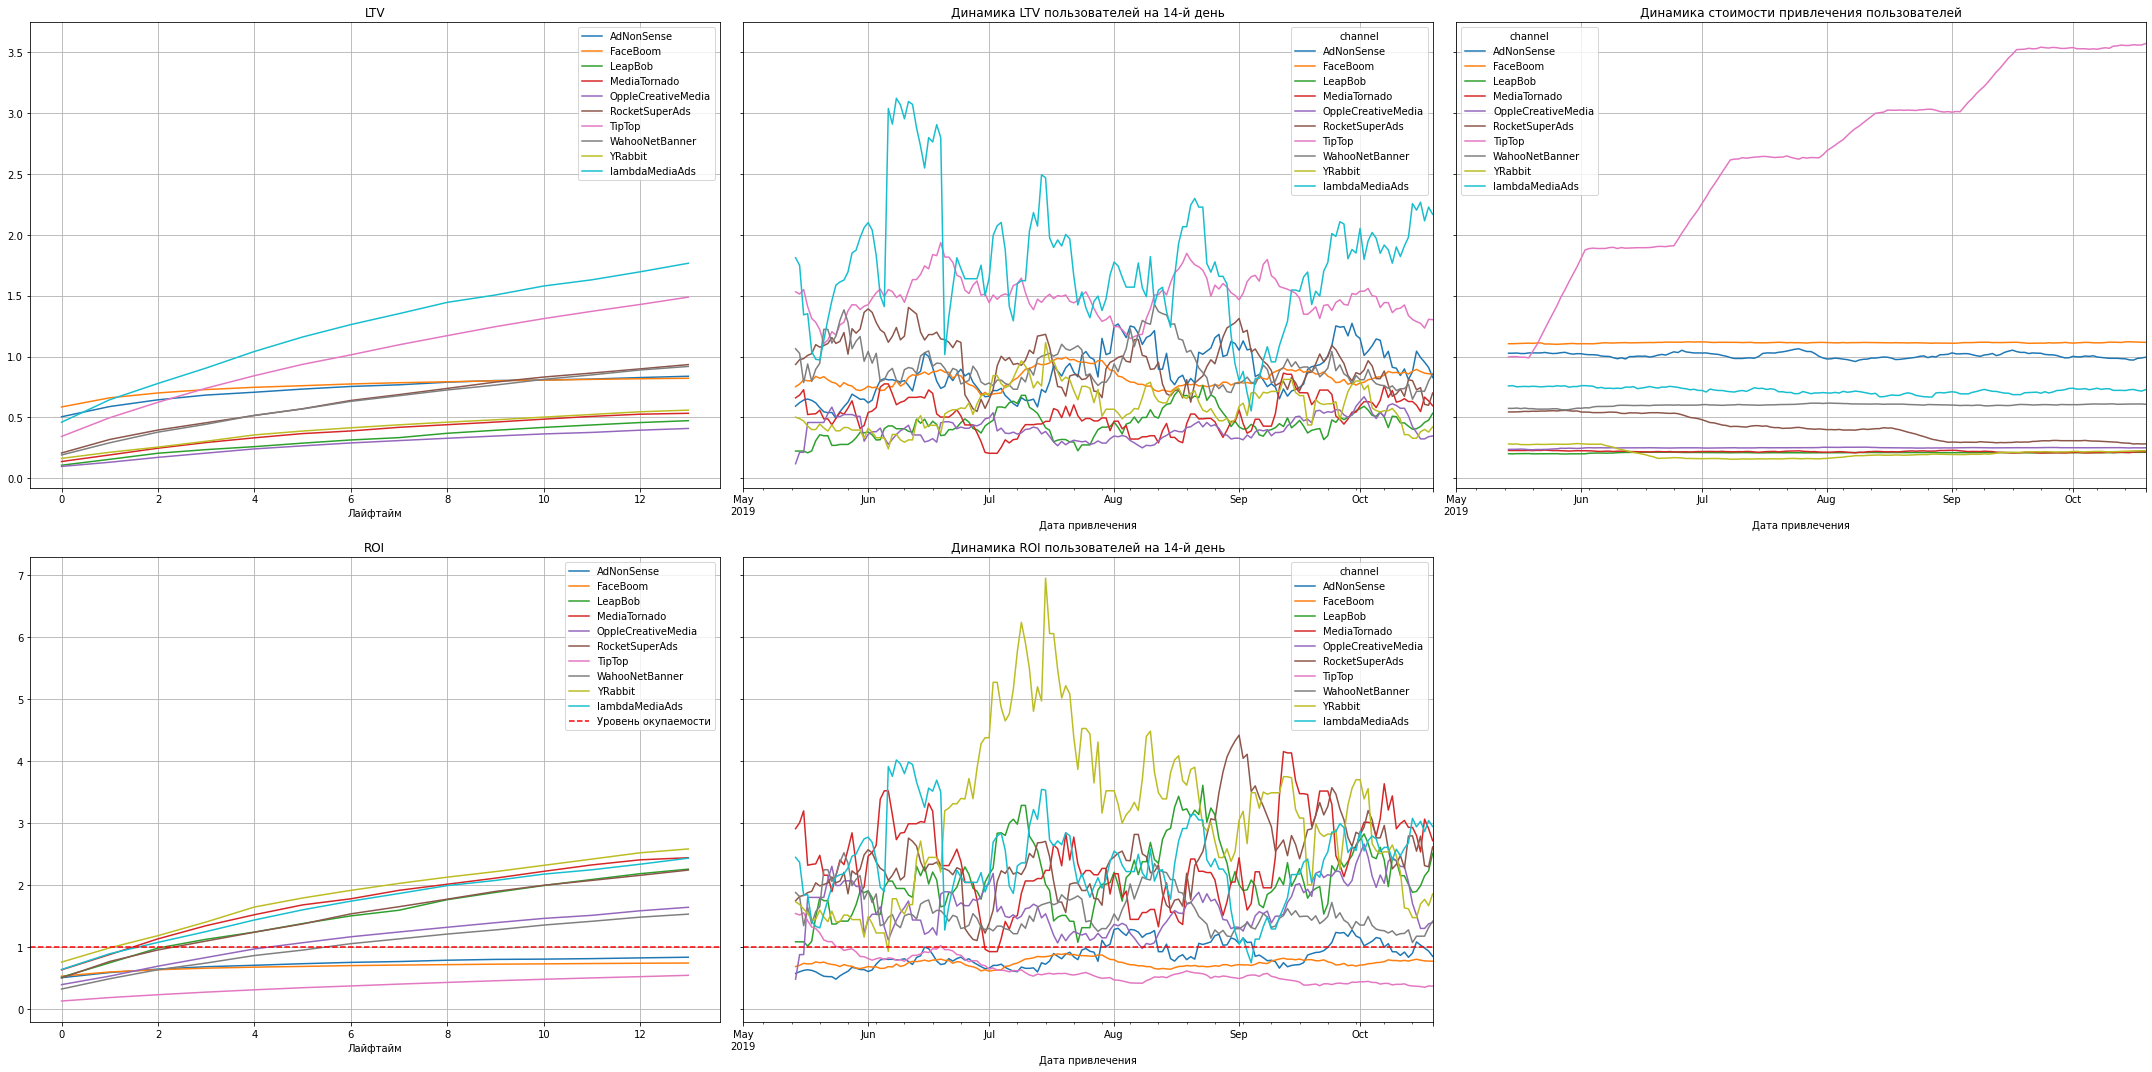

In [23]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

<p style="color:#008080;">CAC - Стоимость привлечения клиентов из канала TipTop значительно выше остальных, остальные же источник из месяца в месяц показывают похожие результаты.
ROI - Реклама окупается везде за исключением LambdaMediaAds, TipTop и FaceBoom.
LTV - Динамика LTV стабильна и без аномалий, лидируют такие каналы как TipTop и LambdaMediaAds.
LTV в динамике показывает тоже самое, лидеры стабильно TipTop и LambdaMediaAds, LambdaMediaAds имеет пиковое значение в июле.
Динамика ROI на 14 день такова же что и ROI в целом, за исключением может быть только Yrabbit в июле и августе мы наблюдаем пик.
</p>

### Окупаемость рекламы с разбивкой по странам.

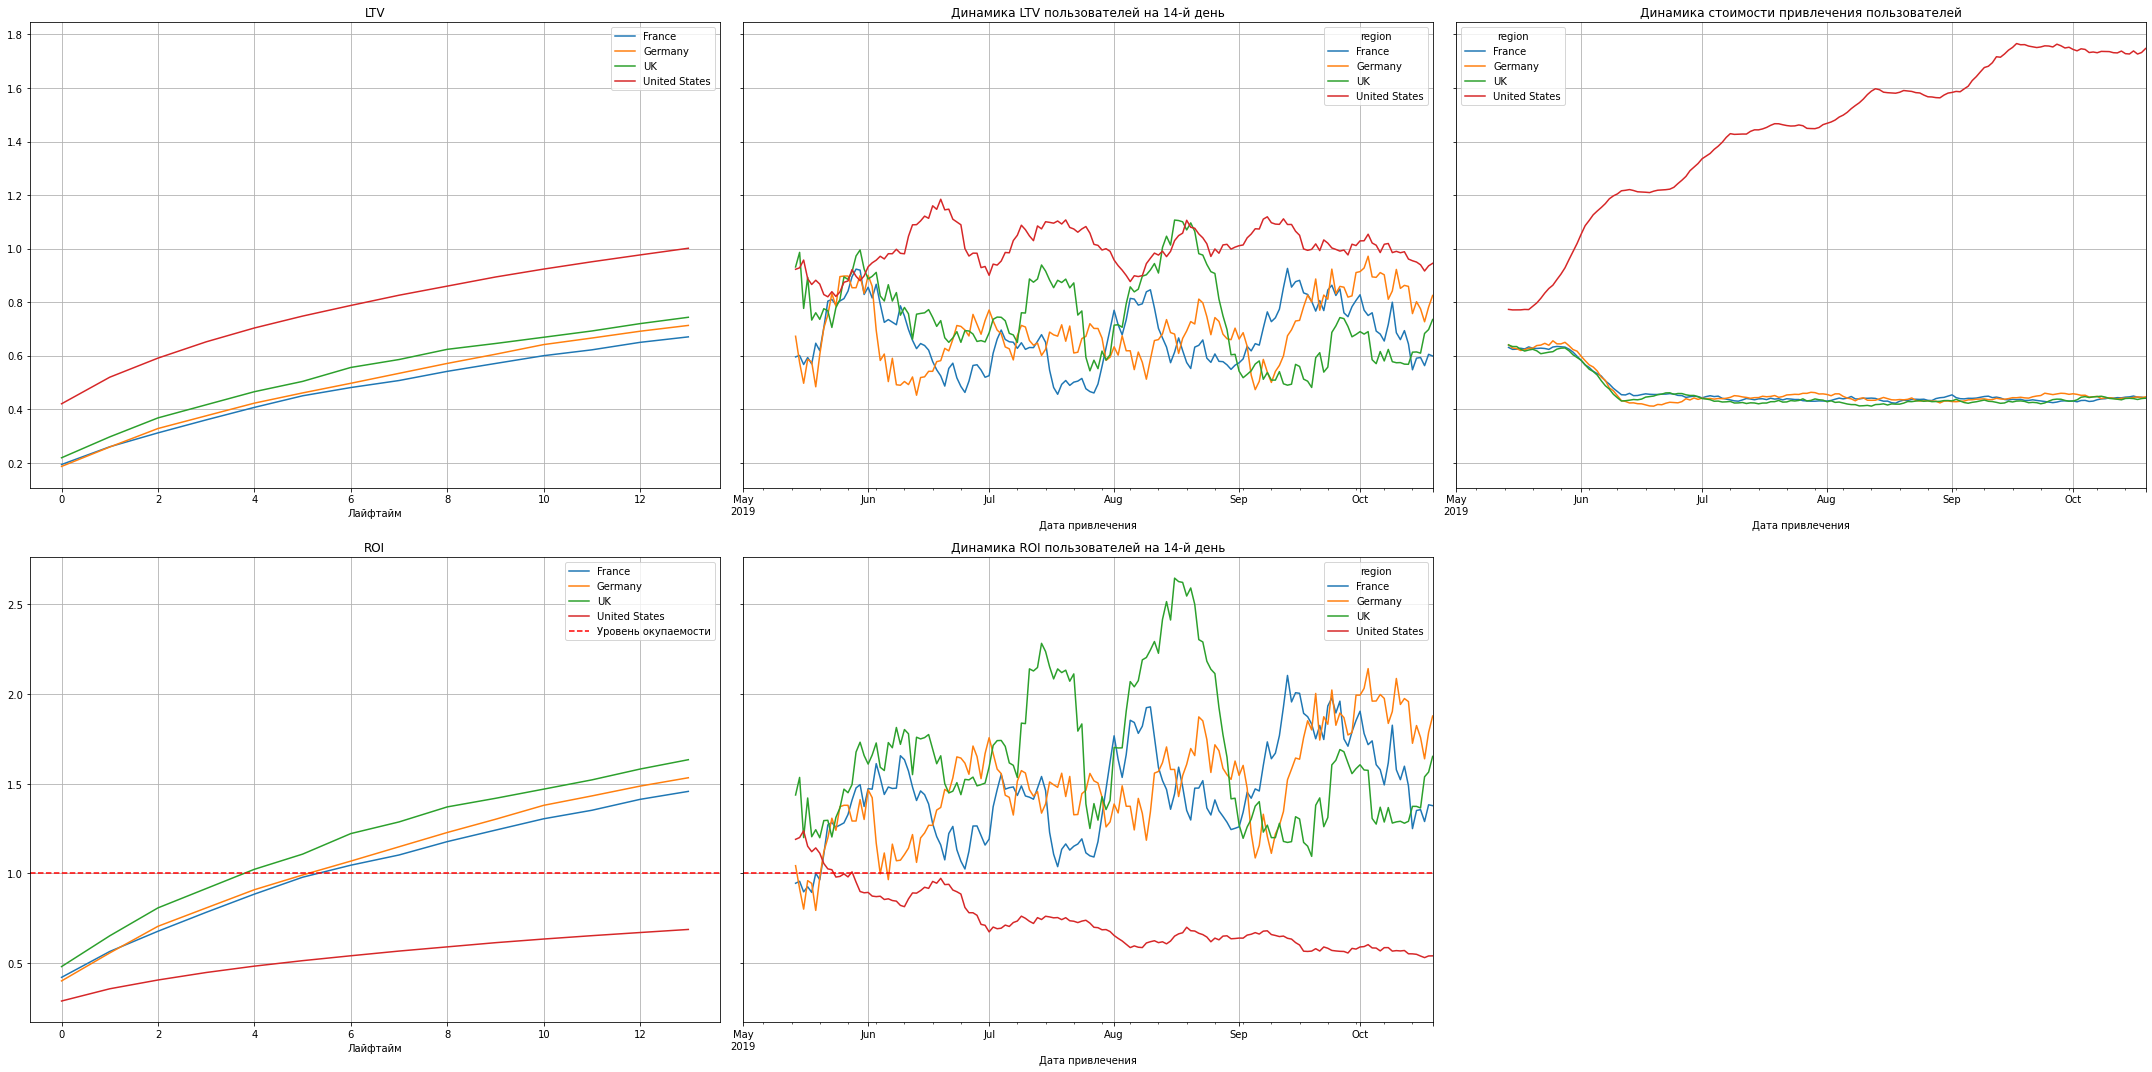

In [24]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<p style="color:#008080;">Unite Ststes -  В САС показывает очень дорогие рузультаты, мы видим что из месяца в месяц привлечения клиентов из этой страны стабильно растет, но живучесть LTV этих клиентов выше чем у остальных, но не значительно как в целом так и в динамике.
В ROI мы видим что окупились все клиенты за исключение Unite Ststes, в динамике же клиенты из Unite Ststes окупались вплоть до июля.
</p>

### Окупаемость рекламы с разбивкой по устройствам.

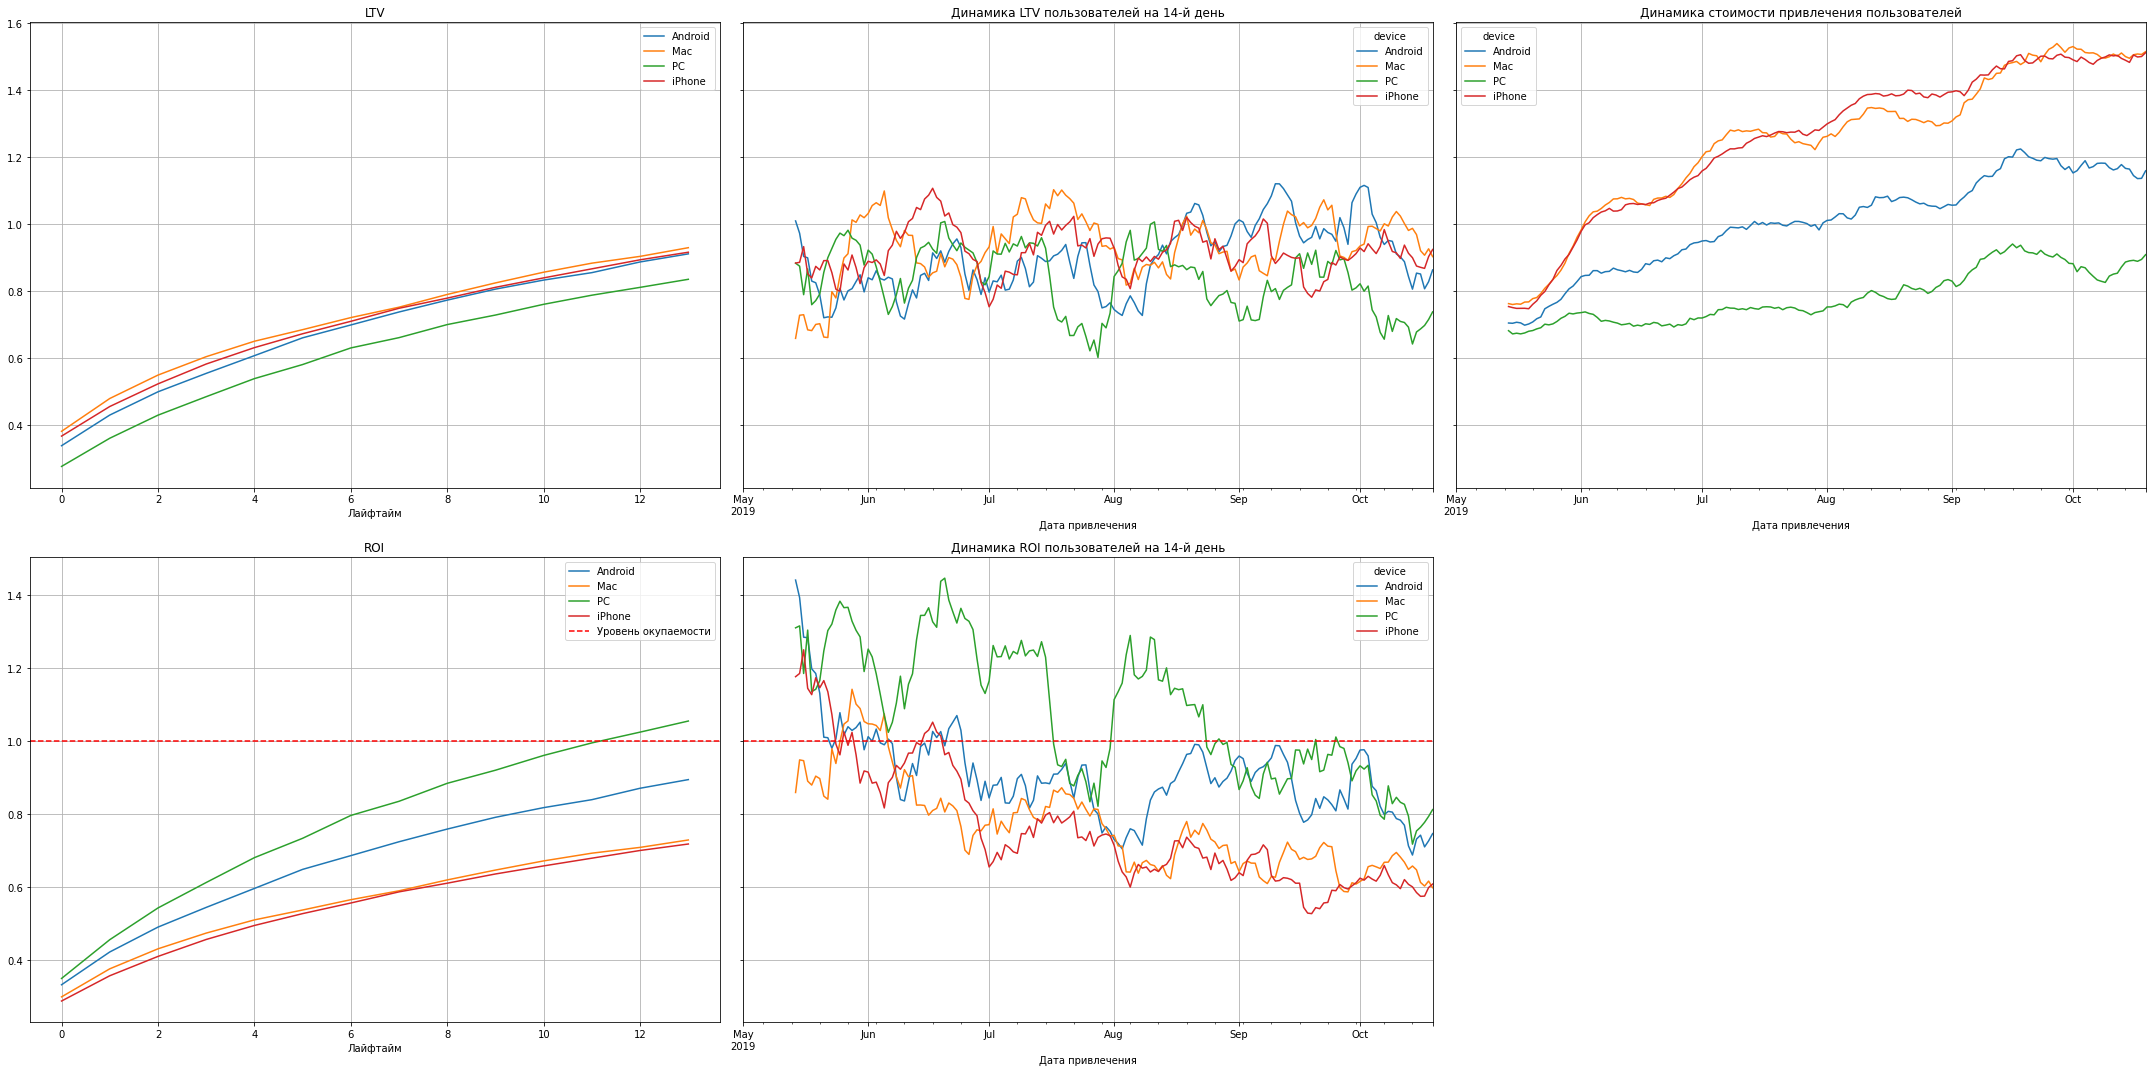

In [25]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<p style="color:#008080;">CAC по устройствам стабилен, дороже всего обходятся клиенты IPhone и Mac.
LTV - нет не каких аномалий , всё стабильно.
ROI - Пользователи Android окупаются ,но лишь ближе к 14 дню, пользователи PC начинают свою окупаемость с 7 дня, пользователи Iphone и Mac не окупаются вовсе.
ROI  в динамике же приблизительнотоже самое, Android окупается, но с большим трудом, пользователи PC окупаются стабильно,MAC и IPhone не окупаются вовсе.
</p>

### Конверсия и удержание с разбивкой по устройствам.

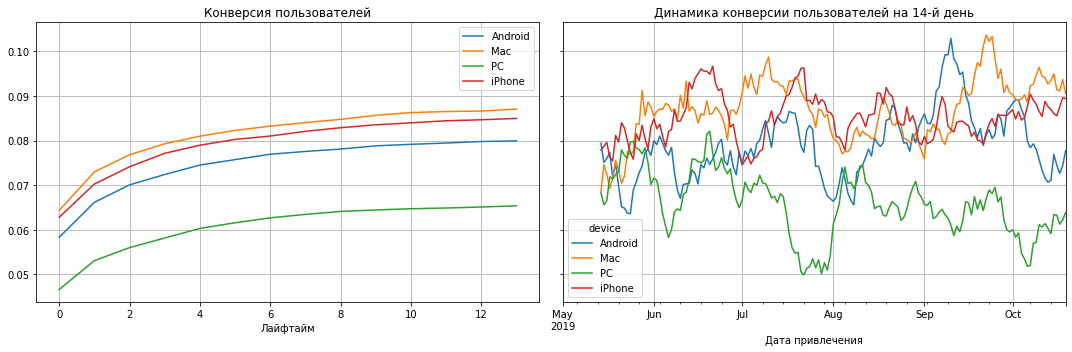

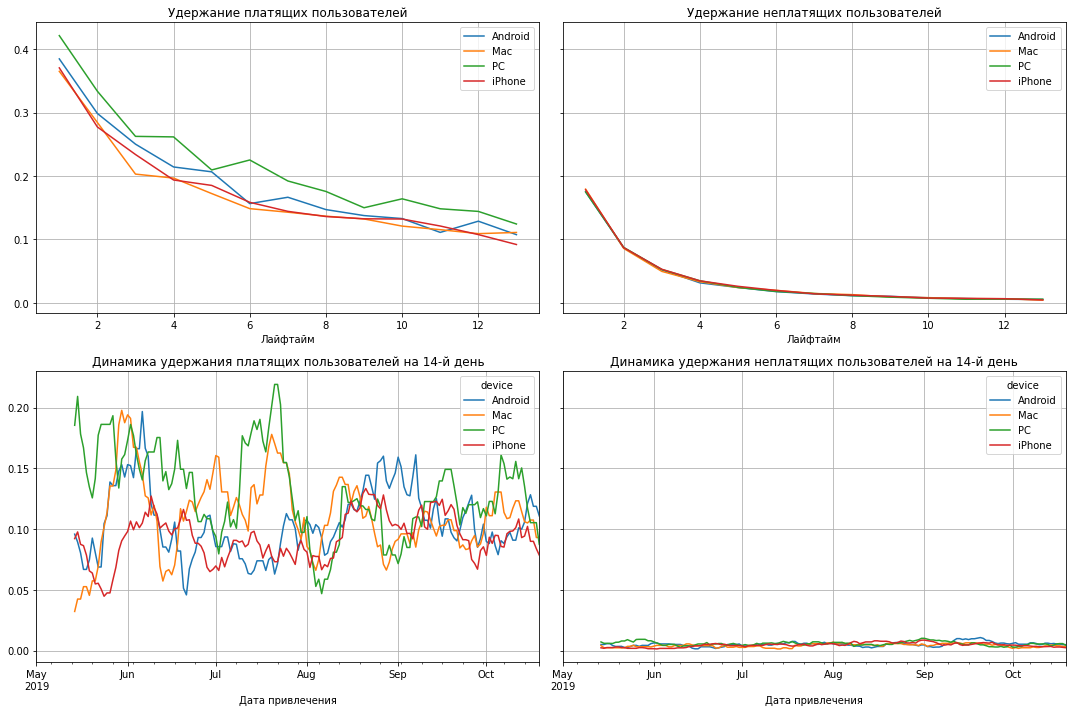

In [26]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 



<p style="color:#008080;"> Конверсии везде стабильно, разве что владельцы PC ниже остальных.
    Удержания стабильно у всех, без аномалий.
    Можно отметить что владельцы PC при относительно низкой конверсии имеют куда лучшее удержание.
    
</p>

### Конверсия и удержание с разбивкой по странам.

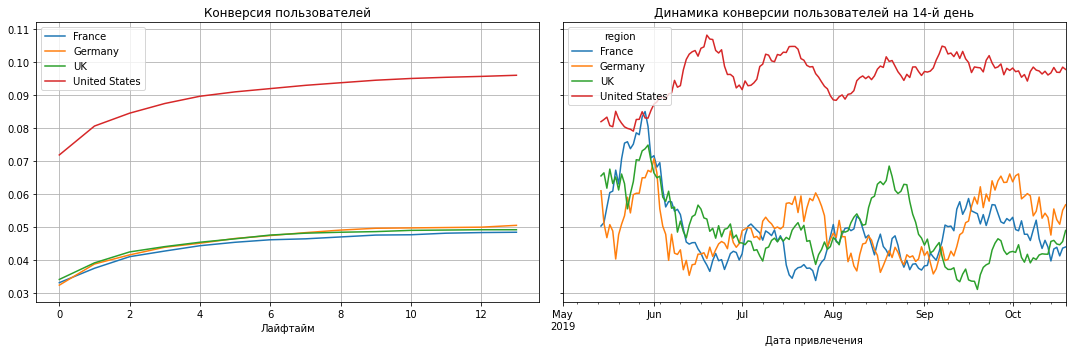

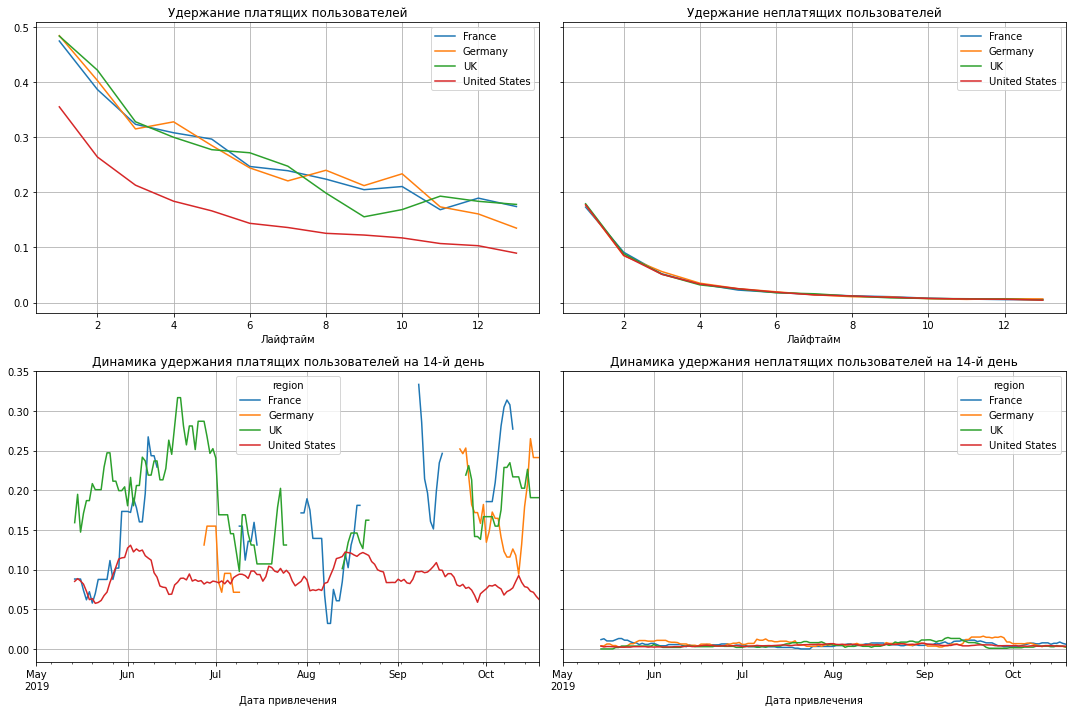

In [27]:
# смотрим конверсии с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<p style="color:#008080;"> Конверсия пользователей из United States значительно выше чем у остальных, но удержание очень низкое.
Это уже зацепка.
    
</p>

### Конверсия и удержание с разбивкой по источникам.

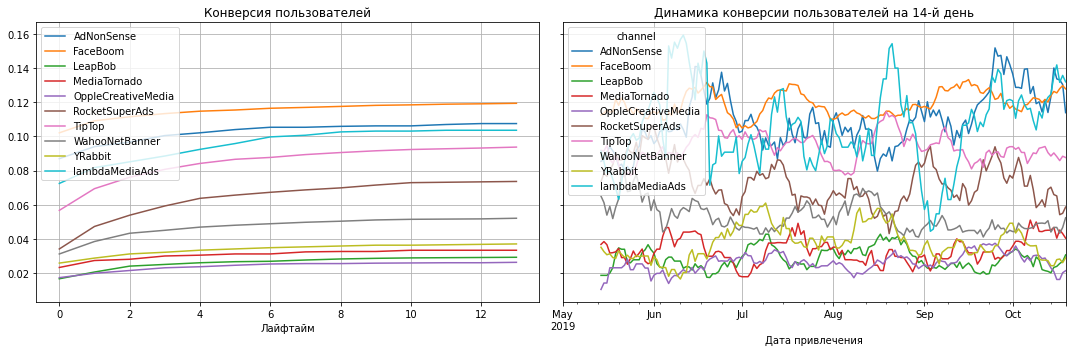

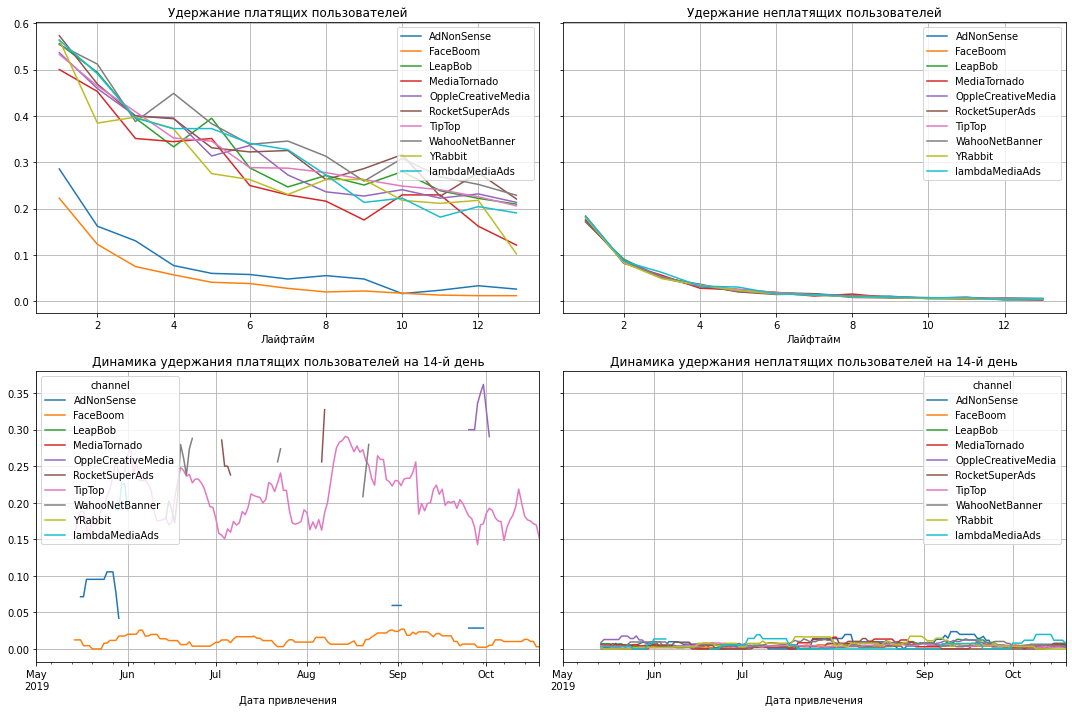

In [28]:
# смотрим конверсию с разбивкой по источникам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по источникам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<p style="color:#008080;"> Конверсии источников без пиков и аномалий, а вот удержание показывает что FaceBoom на 14 день практически на нуле. В динамике же FaceBoom и AdNonSense имеют практически нулевые показание удержание.
    
</p>

<p style="color:#008080;"> Промежуточный вывод по всем графикам таков: Аномалии замеченны в нескольких рекламных кампаниях, таких как AdNonSense и FaceBoom, прибыль от них очень близка у нулю, так же есть нюансы по США, клиенты из этого региона обходятся дорого и не оправдывают вложенных средств что в принципе можно сказать и про Iphone и Mac.
В США очень хорошая конверсия, но плохое удержание.
Сас для для TipTop из месяца в месяц стремится вверх, анномально быстрый рост средней стоимости одного клиента.
    
</p>

# Шаг 6. Напишим выводы
- Выделим причины неэффективности привлечения пользователей;
- Сформируем рекомендации для отдела маркетинга для повышения эффективности.

<div class="alert alert-info"style="border-radius: 10px; box-shadow: 2px 2px 2px;border: 1px solid ">
<b> ОБЩИЙ ВЫВОД</b>
Значительные средства вложены в привлечения клиентов в кампании FaceBoom, а именно практически треть всего рекламного бюджета при том что именно этот источник дал самое низкое удержание.

Так же низкий уровень удержание имеют пользователи из Unatet States и так же пользователи Iphone и Mac хоть и имеют достойную конверсию и удержание, но практически не их привлечение не приводит к доходам, а именно показатель окупаемости равен примерно 80%.
    
    
    
</div>   

<div class="alert alert-info"style="border-radius: 10px; box-shadow: 2px 2px 2px;border: 1px solid ">
<b> ОБЩИЙ ВЫВОД</b>
Конверсия в США менее 70%, удержание к 14 дню не привышает 10%, что касается остальных стран то их конверсия ровна приблизительно 40% ,а удержание к 14 дню 20%.
Конверсия для FaceBoom и AdNonSense 10 -12% , удержание менее 10%.
Так же среднняя стоимость привлечения одного клиента САС , если в остальных регионах это показатель примерно 0,3, то показатель САС в США выше чем 1.0.Сас для канала TipTop так же имеет анамально большое значение по сравнению с остальными, TipTop имеет пиковое значнени равное 3.5, когда остальные канала не превышают 1.0 можно сделать вывод что с этого канала в среднем один пользователь обходится в 3.5 раза дороже чем с остальных. САС по IPhone и MAC обходится дороже нежелеи для Android и PC 1.0 против 08 и 06 у Android и PC.
    
    
    
</div>   

<div class="alert alert-info"style="border-radius: 10px; box-shadow: 2px 2px 2px;border: 1px solid ">
<b> РЕКОМЕНДАЦИИ</b>
Сделать акцент в рекламе прежде всего на пользователей из Великобритании, Германии и Франции,  а так же на пользователей PC  и Android , а так же в рекламные кампании за исключение FaceBoom, TipTop и AdNonSense именно эти 3 кампании не окупаются и помимо этого ещё FaceBoom и AвNonSense имеют практически нулевое удержание.
Вкладывать в рекламы в США не имеет смысла т.к судя по всему это не целевой пользователь нашего приложения и также не нужно вкладывать в рекламные кампании таких источников как FaceBoom, TipTop и AdNonSense.
Придерживаясь этих правил наша реклама выйдет на окупаемость.
</div>   